<a href="https://colab.research.google.com/github/plue1011/PyTorch/blob/master/practice/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://hilinker.hatenablog.com/entry/2018/06/23/204910

In [0]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np
import matplotlib.pyplot as plt


# 1. データセット作成

In [0]:
def make_dataset(data_size, data_length=100, freq=60., noise=0.02):
    """
    params
      data_size : データセットサイズ
      data_length : 各データの時系列長
      freq : 周波数
      noise : ノイズの振幅
    returns
      train_x : トレーニングデータ（t=1,2,...,size-1の値)
      train_t : トレーニングデータのラベル（t=sizeの値）
    """
    train_x = []
    train_t = []

    for offset in range(data_size):
        train_x.append([[math.sin(2 * math.pi * (offset + i) / freq) + np.random.normal(loc=0.0, scale=noise)] for i in range(data_length)])
        train_t.append([math.sin(2 * math.pi * (offset + data_length) / freq)])

    return train_x, train_t

In [0]:
# 一般に[t_nのときのsinの値]には、ベクトルが入るためリストになっている

# train_x[0] = [[t_0のときのsinの値], [t_1のときのsinの値], ..., [t_100のときのsinの値]]
# train_x[1] = [[t_1のときのsinの値], [t_2のときのsinの値], ..., [t_101のときのsinの値]]
# .
# .
# .
# train_x[N] = [[t_Nのときのsinの値], [t_N+1のときのsinの値], ..., [t_N+100のときのsinの値]]

# train_t = [[t_101のときのsinの値], [t_102のときのsinの値], ... ]

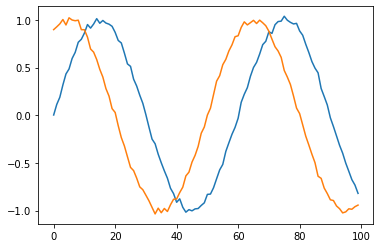

In [34]:
# 作成されるデータの確認
sample_train_x, sample_train_t = make_dataset(20)
sample_data_0 = [i[0] for i in sample_train_x[0]]
sample_data_10 = [i[0] for i in sample_train_x[10]]
plt.plot(range(len(sample_data_0)), sample_data_0)
plt.plot(range(len(sample_data_10)), sample_data_10)
plt.show()

# 2. モデル作成

In [0]:
class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0) #LSTM層
        output = self.output_layer(output[:, -1, :]) #全結合層

        return output

# 3. トレーニング

In [0]:
training_size = 100 #traning dataのデータ数
epochs_num = 1000 #traningのepoch回数
hidden_size = 5 #LSTMの隠れ層の次元数

train_x, train_t = make_dataset(training_size) #Datasetの作成

model = Predictor(1, hidden_size, 1) #modelの宣言
criterion = nn.MSELoss() #評価関数の宣言
optimizer = SGD(model.parameters(), lr=0.01) #最適化関数の宣言

In [88]:
for epoch in range(epochs_num):
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    for i in range(training_size):
        optimizer.zero_grad()
        data = torch.tensor([train_x[i]])
        label = torch.tensor([train_t[i]])

        output = model(data)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        training_accuracy += np.sum(np.abs((output.data - label.data).numpy()) < 0.1) #outputとlabelの誤差が0.1以内なら正しいとみなす。
    training_accuracy /= training_size
    print('%d loss: %.3f, training_accuracy: %.5f' % (epoch + 1, running_loss, training_accuracy))

1 loss: 36.941, training_accuracy: 0.07000
2 loss: 21.765, training_accuracy: 0.08000
3 loss: 10.628, training_accuracy: 0.10000
4 loss: 6.026, training_accuracy: 0.16000
5 loss: 4.421, training_accuracy: 0.21000
6 loss: 3.726, training_accuracy: 0.29000
7 loss: 3.327, training_accuracy: 0.30000
8 loss: 3.050, training_accuracy: 0.32000
9 loss: 2.836, training_accuracy: 0.34000
10 loss: 2.661, training_accuracy: 0.36000
11 loss: 2.513, training_accuracy: 0.36000
12 loss: 2.385, training_accuracy: 0.39000
13 loss: 2.272, training_accuracy: 0.39000
14 loss: 2.172, training_accuracy: 0.39000
15 loss: 2.082, training_accuracy: 0.41000
16 loss: 2.000, training_accuracy: 0.42000
17 loss: 1.926, training_accuracy: 0.42000
18 loss: 1.857, training_accuracy: 0.42000
19 loss: 1.794, training_accuracy: 0.42000
20 loss: 1.735, training_accuracy: 0.45000
21 loss: 1.680, training_accuracy: 0.46000
22 loss: 1.629, training_accuracy: 0.47000
23 loss: 1.580, training_accuracy: 0.47000
24 loss: 1.535, t

KeyboardInterrupt: ignored

In [89]:
model.eval()

data = torch.tensor([train_x[0]])
pred = model(data)
pred

tensor([[-0.8539]], grad_fn=<AddmmBackward>)

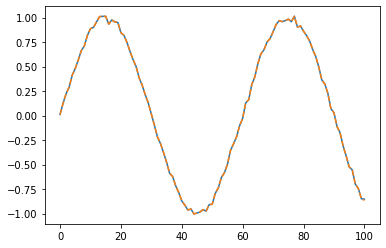

In [91]:
# 予測と答えの比較
train_data = [i[0] for i in train_x[0]]
plt.plot(range(len(train_data)+1), train_data+[pred])
plt.plot(range(len(train_data)+1), train_data+[train_t[0][0]], linestyle='--')
plt.show()

ぴったり重なっている